In [1]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, vstack, hstack
import fitsio
from astropy.io import fits
import healpy as hp
from astropy import wcs

from scipy.ndimage.filters import gaussian_filter

In [2]:
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'figure.facecolor':'w'} 
plt.rcParams.update(params)

In [3]:
ccdnamenumdict = {'S1': 25, 'S2': 26, 'S3': 27, 'S4':28,
                  'S5': 29, 'S6': 30, 'S7': 31,
                  'S8': 19, 'S9': 20, 'S10': 21, 'S11': 22, 'S12': 23,
                  'S13': 24,
                  'S14': 13, 'S15': 14, 'S16': 15, 'S17': 16, 'S18': 17,
                  'S19': 18,
                  'S20': 8, 'S21': 9, 'S22': 10, 'S23': 11, 'S24': 12,
                  'S25': 4, 'S26': 5, 'S27': 6, 'S28': 7,
                  'S29': 1, 'S30': 2, 'S31': 3,
                  'N1': 32, 'N2': 33, 'N3': 34, 'N4': 35,
                  'N5': 36, 'N6': 37, 'N7': 38,
                  'N8': 39, 'N9': 40, 'N10': 41, 'N11': 42, 'N12': 43,
                  'N13': 44,
                  'N14': 45, 'N15': 46, 'N16': 47, 'N17': 48, 'N18': 49,
                  'N19': 50,
                  'N20': 51, 'N21': 52, 'N22': 53, 'N23': 54, 'N24': 55,
                  'N25': 56, 'N26': 57, 'N27': 58, 'N28': 59,
                  'N29': 60, 'N30': 61, 'N31': 62}
ccdnamenumdict_inv = {aa: bb for bb, aa in ccdnamenumdict.items()}

ccdnum_list = [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 62]

ccd_ra = [-0.31244368,-0.00214103, 0.30855858,-0.46789986,-0.1573787 , 0.15336207,
  0.4637642 ,-0.62325889,-0.312972  ,-0.00212455, 0.30866507, 0.61908193,
 -0.77859061,-0.46870955,-0.15780883, 0.15334942, 0.46418217, 0.77441054,
 -0.77876058,-0.46892617,-0.15799484, 0.15333136, 0.46448109, 0.77444204,
 -0.93389515,-0.624237  ,-0.31362077,-0.00213867, 0.30892024, 0.61974856,
  0.92929411,-0.93410772,-0.62439031,-0.31379523,-0.00251046, 0.30860373,
  0.61929563, 0.92907893,-0.77928668,-0.46927775,-0.15819325, 0.15315534,
  0.464108  , 0.77408146,-0.7791703 ,-0.46938561,-0.15825837, 0.15269545,
  0.46382537, 0.77383443,-0.6239286 ,-0.31363566,-0.00262614, 0.30814956,
  0.61848423,-0.46862823,-0.15833137, 0.15254403, 0.46295505,-0.31333245,
  0.30765903]

ccd_dec = [ 0.90299039, 0.90274404, 0.90285652, 0.73894001, 0.73933177, 0.73919444,
  0.73865878, 0.5745655 , 0.57508801, 0.57510357, 0.57486577, 0.57414278,
  0.41001556, 0.41059824, 0.41088721, 0.41057117, 0.41032572, 0.40963196,
  0.24595122, 0.24597951, 0.24624207, 0.24619019, 0.24582139, 0.24534302,
  0.08128957, 0.08150002, 0.08130657, 0.08138846, 0.0810964 , 0.08093379,
  0.08089282,-0.08302691,-0.08319348,-0.08340522,-0.08351659,-0.08366242,
 -0.08355805,-0.08365399,-0.24756494,-0.2479717 ,-0.24812127,-0.24835309,
 -0.2482645 ,-0.2480924 ,-0.41173856,-0.41236738,-0.41281328,-0.41296242,
 -0.41270174,-0.41225407,-0.57638265,-0.57687683,-0.57711492,-0.57725814,
 -0.57674114,-0.74071528,-0.74115162,-0.74130891,-0.74095896,-0.9049206 ,
 -0.90515532]

In [4]:
fringe_dir = '/global/homes/d/djschleg/cosmo/staging/decam/DECam_CP-Fringe'
image_dir = '/global/project/projectdirs/cosmo/staging/'
surveyccd_path = '/global/project/projectdirs/cosmo/work/legacysurvey/dr9/survey-ccds-decam-dr9.fits.gz'
blob_dir = '/global/project/projectdirs/desi/users/rongpu/dr9/decam_ccd_blob_mask'

sky_dir = '/global/project/projectdirs/desi/users/rongpu/dr9/fringe/smooth_sky'
plot_dir = '/global/project/projectdirs/desi/users/rongpu/dr9/fringe/plots'
output_dir = '/global/project/projectdirs/desi/users/rongpu/dr9/fringe/data'


# Load CCD list
ccd_columns = ['expnum', 'image_filename', 'image_hdu', 'ccdname', 'filter', 'mjd_obs', 'ccd_cuts']
ccd = fitsio.read(surveyccd_path, columns=ccd_columns)
# ccd = fitsio.read(surveyccd_path)
ccd = Table(ccd)
mask = ccd['ccd_cuts']==0
mask &= ccd['filter']=='z' # include only z-band images
ccd = ccd[mask]
print(len(ccd))

# Find CCDs around some MJD
mask = (ccd['mjd_obs']>(57815-4)) & (ccd['mjd_obs']<(57815+4)) # DECaLS observing run starting Feb 28, 2017
mask |= ((ccd['mjd_obs']>(58359-2)) & (ccd['mjd_obs']<(58359+27))) # Starting Aug 28, 2018
mask |= ((ccd['mjd_obs']>(58423-2)) & (ccd['mjd_obs']<(58423+30))) # Two runs starting Oct 28, 2018
mask |= ((ccd['mjd_obs']>(57893-2)) & (ccd['mjd_obs']<(57893+30))) # Two runs starting May 18, 2017
ccd = ccd[mask]
print(len(ccd))

# Only use data from specific nights
# Identify the observing date of each CCD
str_loc = np.char.find(np.array(ccd['image_filename'], dtype='str'), '/CP201')
ccd['obs_date'] = np.array([ccd['image_filename'][i][str_loc[i]+1:str_loc[i]+11] for i in range(len(ccd))])
obs_date_list = ['CP20170302', 'CP20170303', 'CP20170304', 'CP20170305', 'CP20170519', 'CP20170520', 
                 'CP20180828', 'CP20180829', 'CP20180831', 'CP20180903', 'CP20180908', 'CP20180913', 
                 'CP20180914', 'CP20180916', 'CP20180917', 'CP20180920', 'CP20180921']
mask = np.in1d(ccd['obs_date'], obs_date_list)
ccd = ccd[mask]
print(len(ccd))

1682129
172157
97651


In [5]:
ccd_all = ccd.copy()

In [6]:
obs_date = obs_date_list[0]
mask = ccd['obs_date']==obs_date
np.random.seed(123)
expnum = np.random.choice(np.unique(ccd['expnum'][mask]))
print(expnum)
mask &= ccd['expnum']==expnum
ccd = ccd[mask]
print(len(ccd))

625492
61


__Original CP image__

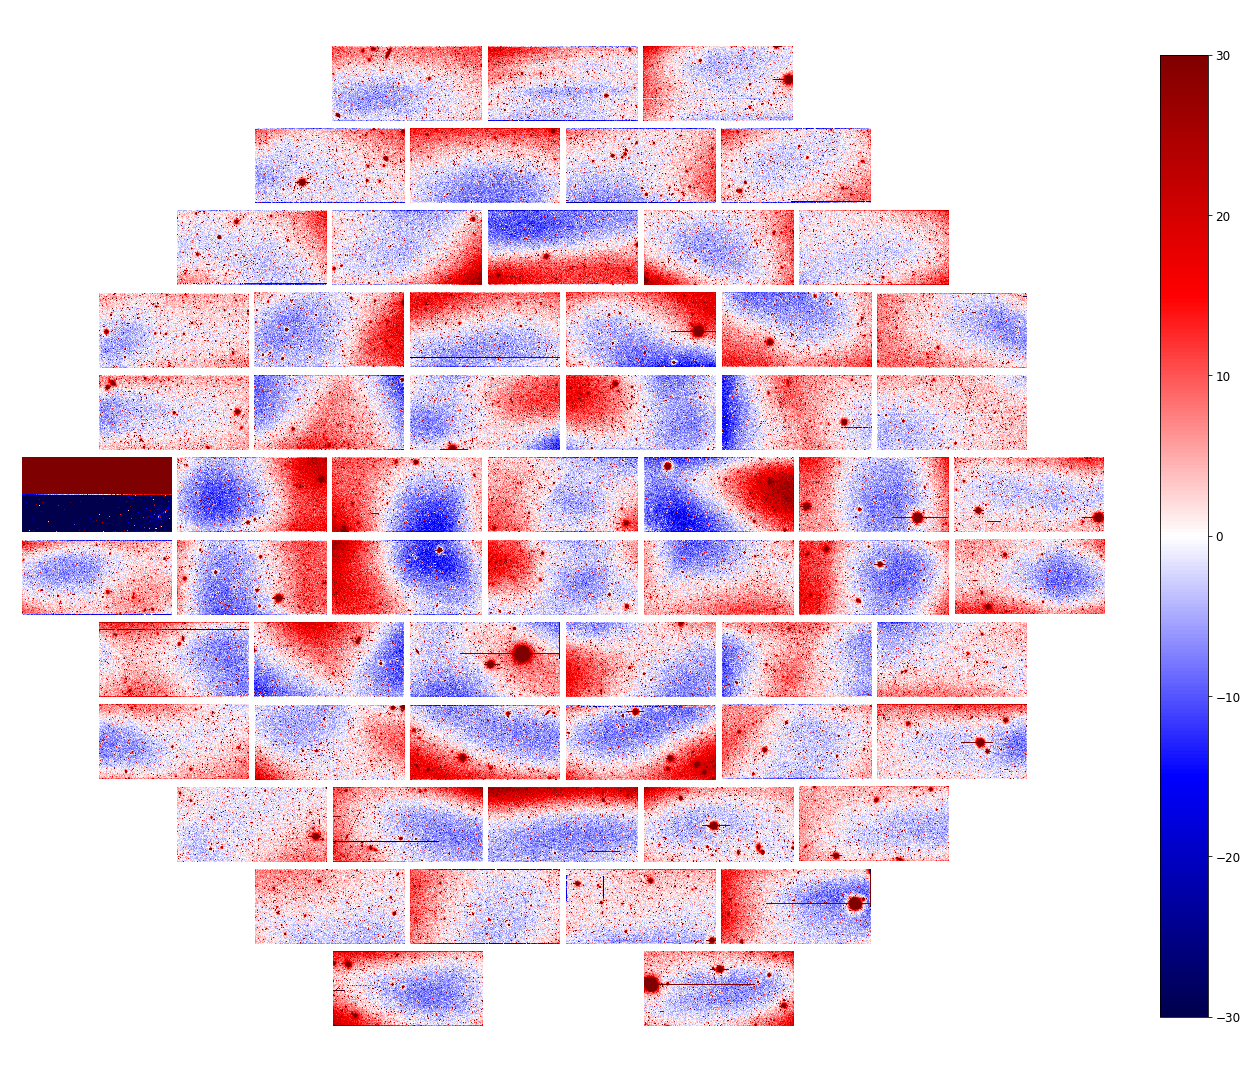

In [26]:
pix_size = 0.262/3600
vrange = 3e1

obs_date = obs_date_list[0]
mask = ccd['obs_date']==obs_date
np.random.seed(123)
expnum = np.random.choice(np.unique(ccd['expnum'][mask]))

ccd_index = np.where((ccd['expnum']==expnum))[0][0]
img_fn = os.path.join('/global/cfs/cdirs/cosmo/staging/', ccd['image_filename'][ccd_index].strip())

# plt.figure(figsize=(25, 23.86))
plt.figure(figsize=(17, 15))

for ii, ccdnum in enumerate(ccdnum_list):
    
    try:
        img = fits.getdata(img_fn, extname=ccdnamenumdict_inv[ccdnum])
    except:
        continue
    ysize, xsize = img.shape        
    ra, dec = ccd_ra[ii], ccd_dec[ii]
    
    # naive sky estimation
    mask = (img<np.percentile(img.flatten(), 95))
    median_sky = np.median(img[mask].flatten())

    img1 = img - median_sky
    img1[~np.isfinite(img1)] = 0
    img1 = gaussian_filter(img1, 3, mode='reflect', truncate=3)

    fig = plt.imshow(img1.T, cmap='seismic', vmin=-vrange, vmax=vrange, 
               extent=(ra-ysize*pix_size/2, ra+ysize*pix_size/2, dec-xsize*pix_size/2, dec+xsize*pix_size/2))
    
plt.axis([1.1, -1.1, -1.05, 1.05])
plt.axis('off')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.tight_layout()
plt.colorbar(fraction=0.04, pad=0.04)
# plt.savefig('new_fringe_smooth_focal_plane.png')
plt.show()

__Sky pattern__

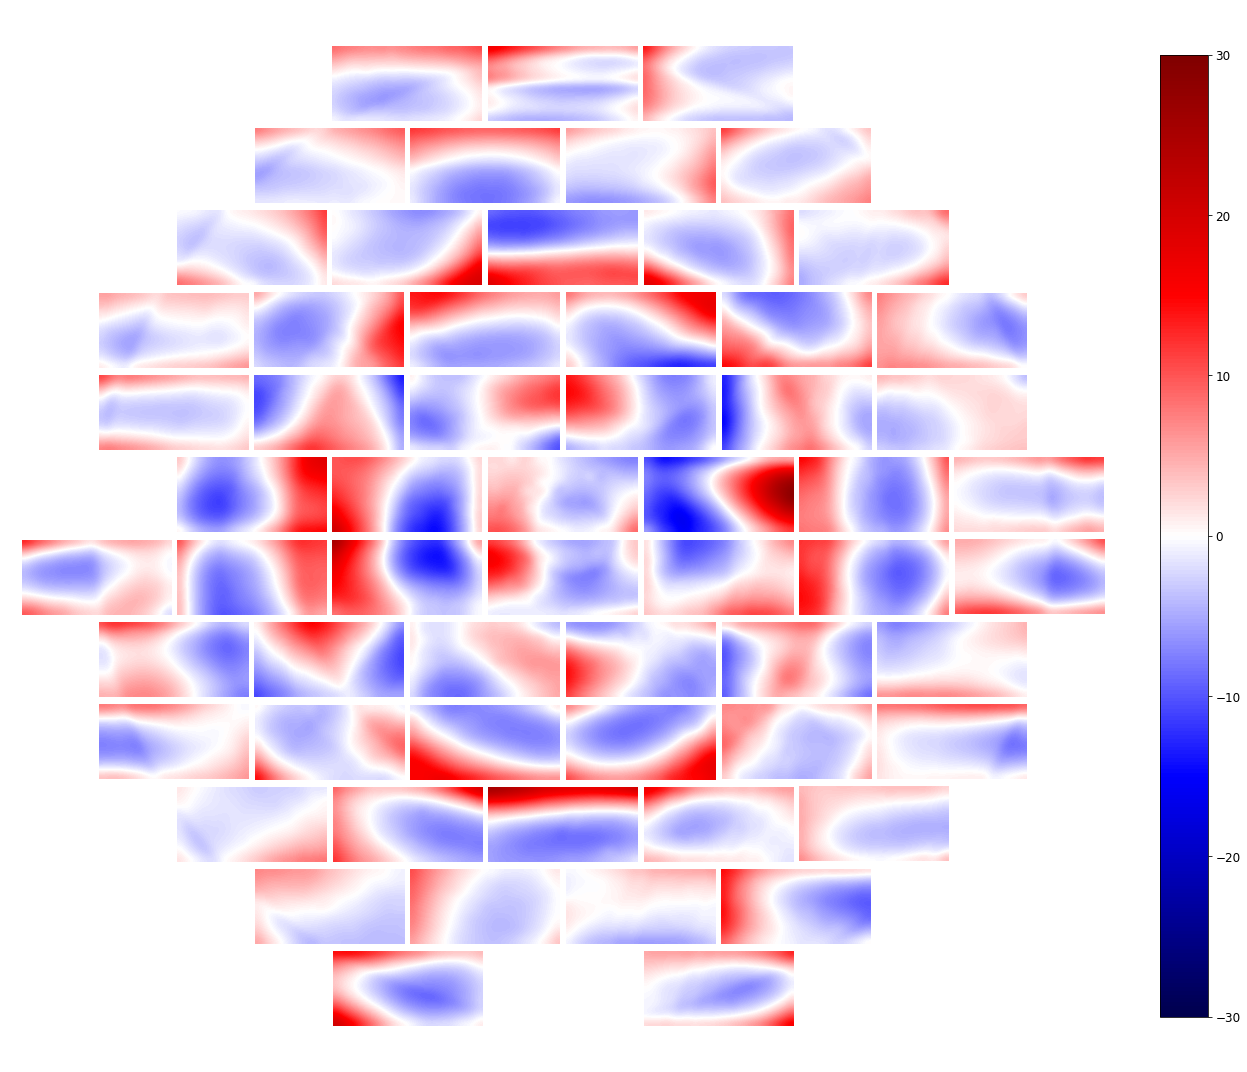

In [29]:
hdu_index_list = np.arange(1, 62)
pix_size = 0.262/3600
vrange = 3e1

obs_date = obs_date_list[0]
mask = ccd['obs_date']==obs_date
np.random.seed(123)
expnum = np.random.choice(np.unique(ccd['expnum'][mask]))

ccd_index = np.where((ccd['expnum']==expnum))[0][0]
img_fn = os.path.join('/global/cfs/cdirs/cosmo/staging/', ccd['image_filename'][ccd_index].strip())

# plt.figure(figsize=(25, 23.86))
plt.figure(figsize=(17, 15))

for ii, ccdnum in enumerate(ccdnum_list):
    
    if ccdnum==31:
        continue
    ra, dec = ccd_ra[ii], ccd_dec[ii]
    
    hdu_index = hdu_index_list[ii]
    smooth_sky = np.load(os.path.join(sky_dir, 'smooth_sky_{}_{}.npy'.format(obs_date, hdu_index)))
    ysize, xsize = smooth_sky.shape
    hdulist = fits.open(img_fn)
    frgscale = (hdulist[ccd['image_hdu'][ccd_index]].header)['FRGSCALE']

    fig = plt.imshow((smooth_sky*frgscale).T, cmap='seismic', vmin=-vrange, vmax=vrange, 
               extent=(ra-ysize*pix_size/2, ra+ysize*pix_size/2, dec-xsize*pix_size/2, dec+xsize*pix_size/2))
    
plt.axis([1.1, -1.1, -1.05, 1.05])
plt.axis('off')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.tight_layout()
plt.colorbar(fraction=0.04, pad=0.04)
# plt.savefig('new_fringe_smooth_focal_plane.png')
plt.show()

__CP image after removing the sky pattern__

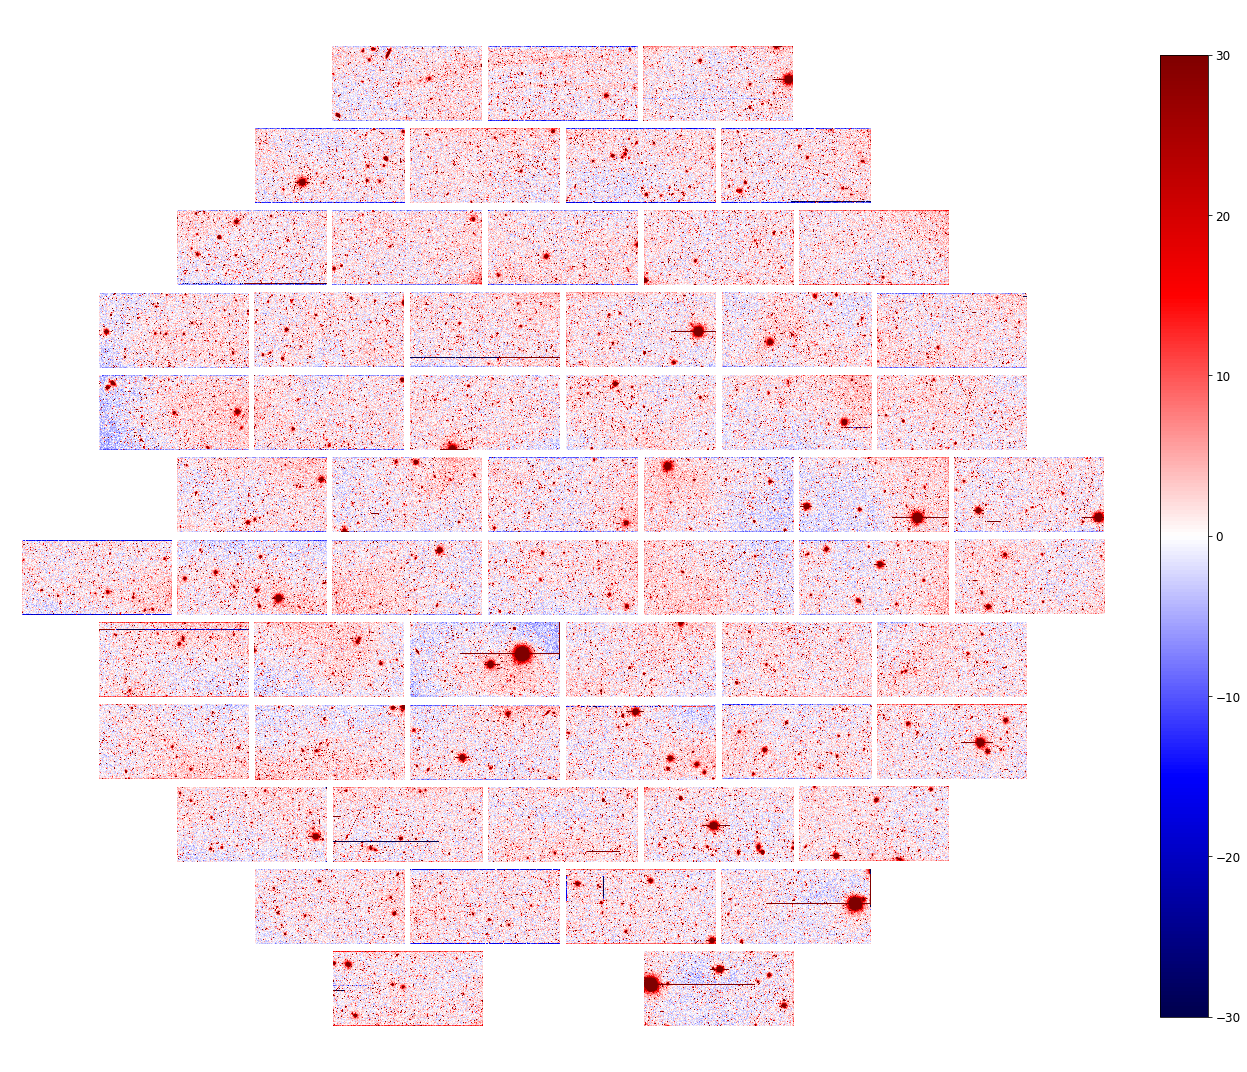

In [17]:
hdu_index_list = np.arange(1, 62)
pix_size = 0.262/3600
vrange = 3e1

obs_date = obs_date_list[0]
mask = ccd['obs_date']==obs_date
np.random.seed(123)
expnum = np.random.choice(np.unique(ccd['expnum'][mask]))

ccd_index = np.where((ccd['expnum']==expnum))[0][0]
img_fn = os.path.join('/global/cfs/cdirs/cosmo/staging/', ccd['image_filename'][ccd_index].strip())

# plt.figure(figsize=(25, 23.86))
plt.figure(figsize=(17, 15))

for ii, ccdnum in enumerate(ccdnum_list):
    
    if ccdnum==31:
        continue

    try:
        img = fits.getdata(img_fn, extname=ccdnamenumdict_inv[ccdnum])
    except:
        continue
    ysize, xsize = img.shape        
    ra, dec = ccd_ra[ii], ccd_dec[ii]
    
    # naive sky estimation
    mask = (img<np.percentile(img.flatten(), 95))
    median_sky = np.median(img[mask].flatten())

    img1 = img - median_sky
    img1[~np.isfinite(img1)] = 0
    img1 = gaussian_filter(img1, 3, mode='reflect', truncate=3)
    
    hdu_index = hdu_index_list[ii]
    smooth_sky = np.load(os.path.join(sky_dir, 'smooth_sky_{}_{}.npy'.format(obs_date, hdu_index)))
    ysize, xsize = smooth_sky.shape
    hdulist = fits.open(img_fn)
    frgscale = (hdulist[ccd['image_hdu'][ccd_index]].header)['FRGSCALE']

    fig = plt.imshow((img1-smooth_sky*frgscale).T, cmap='seismic', vmin=-vrange, vmax=vrange, 
               extent=(ra-ysize*pix_size/2, ra+ysize*pix_size/2, dec-xsize*pix_size/2, dec+xsize*pix_size/2))
    
plt.axis([1.1, -1.1, -1.05, 1.05])
plt.axis('off')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.tight_layout()
plt.colorbar(fraction=0.04, pad=0.04)
# plt.savefig('new_fringe_smooth_focal_plane.png')
plt.show()

In [ ]:
hdu_index_list = np.arange(1, 62)
pix_size = 0.262/3600
vrange = 3e1

obs_date = obs_date_list[0]
mask = ccd['obs_date']==obs_date
np.random.seed(123)
expnum = np.random.choice(np.unique(ccd['expnum'][mask]))

ccd_index = np.where((ccd['expnum']==expnum))[0][0]
img_fn = os.path.join('/global/cfs/cdirs/cosmo/staging/', ccd['image_filename'][ccd_index].strip())

for ii, ccdnum in enumerate(ccdnum_list):
    
    if ccdnum==31:
        continue

    try:
        img = fits.getdata(img_fn, extname=ccdnamenumdict_inv[ccdnum])
    except:
        continue
    ysize, xsize = img.shape        
    ra, dec = ccd_ra[ii], ccd_dec[ii]
    
    # naive sky estimation
    mask = (img<np.percentile(img.flatten(), 95))
    median_sky = np.median(img[mask].flatten())

    img1 = img - median_sky
    img1[~np.isfinite(img1)] = 0
    img1 = gaussian_filter(img1, 3, mode='reflect', truncate=3)
    
    hdu_index = hdu_index_list[ii]
    smooth_sky = np.load(os.path.join(sky_dir, 'smooth_sky_{}_{}.npy'.format(obs_date, hdu_index)))
    ysize, xsize = smooth_sky.shape
    hdulist = fits.open(img_fn)
    frgscale = (hdulist[ccd['image_hdu'][ccd_index]].header)['FRGSCALE']
    
    print(median_sky)
    print(frgscale*(np.percentile((smooth_sky).flatten(), 99)-np.percentile((smooth_sky).flatten(), 1)))

2273.12
13.9241709334
2267.68
18.646007195


--------
## Plot all the pre-computed sky images

In [11]:
obs_date_list = ['CP20170302', 'CP20170303', 'CP20170304', 'CP20170305', 'CP20170519', 'CP20170520', 'CP20180828', 'CP20180829', 'CP20180831', 'CP20180901', 'CP20180902', 'CP20180903', 'CP20180904', 'CP20180908', 'CP20180913', 'CP20180914', 'CP20180915', 'CP20180916', 'CP20180917', 'CP20180920', 'CP20180921', 'CP20181031', 'CP20181101']
hdu_index_list = np.arange(1, 62)
sky_dir = '/global/project/projectdirs/desi/users/rongpu/dr9/fringe/smooth_sky'

0 CP20170302


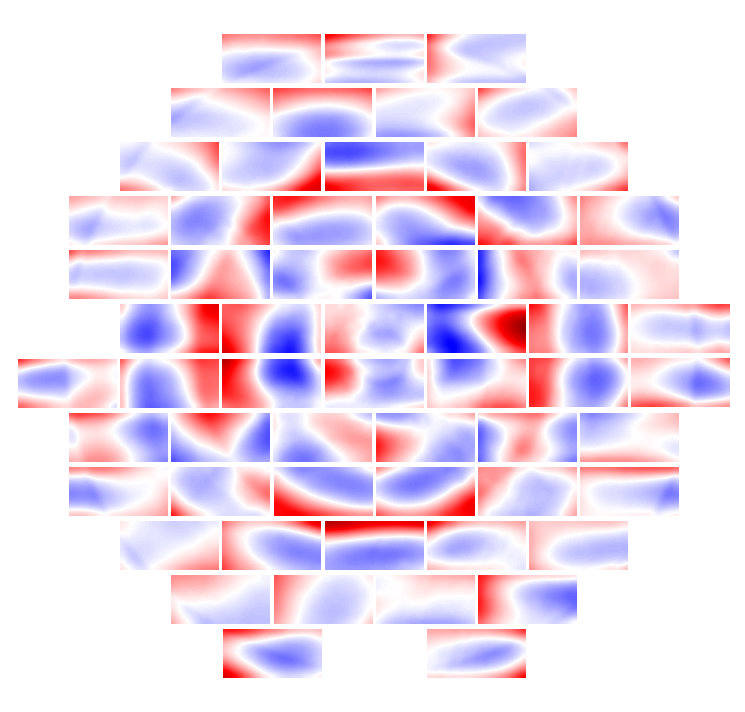

In [12]:
hdu_index_list = np.arange(1, 62)
binsize = 4
pix_size = 0.262/3600*binsize
vrange = 1e-2

for index, obs_date in enumerate(obs_date_list[:1]):
    
    print(index, obs_date)

    plt.figure(figsize=(10.48, 10))

    for ii, ccdnum in enumerate(ccdnum_list):

        if ccdnum==31:
            continue
        ra, dec = ccd_ra[ii], ccd_dec[ii]
        
        hdu_index = hdu_index_list[ii]
        try:
            smooth_sky = np.load(os.path.join(sky_dir, 'smooth_sky_{}_{}.npy'.format(obs_date, hdu_index)))
        except:
            continue
        
        ################ downsize image ################

        # trim edges to enable downsizing
        # trimmed image size need to be multiples of binsize
        trim_size_x = smooth_sky.shape[1] % binsize
        trim_size_y = smooth_sky.shape[0] % binsize
        smooth_sky = smooth_sky[:(smooth_sky.shape[0]-trim_size_y), :(smooth_sky.shape[1]-trim_size_x)]
        # print(smooth_sky.shape)

        # to ignore NAN values, use np.nanmean
        smooth_sky = np.mean(np.mean(smooth_sky.reshape((smooth_sky.shape[0]//binsize, binsize, smooth_sky.shape[1]//binsize,-1)), axis=3), axis=1)

        ################################################

        ysize, xsize = smooth_sky.shape
        fig = plt.imshow((smooth_sky).T, cmap='seismic', vmin=-vrange, vmax=vrange, 
                   extent=(ra-ysize*pix_size/2, ra+ysize*pix_size/2, dec-xsize*pix_size/2, dec+xsize*pix_size/2))

    plt.axis([1.1, -1.1, -1.05, 1.05])
    plt.axis('off')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.tight_layout()
    plt.savefig('/global/project/projectdirs/desi/www/users/rongpu/plots/dr9dev/ccd_fringe_plots/smooth_sky/smooth_sky_{}.png'.format(obs_date))
    if index==0:
        plt.show()
    plt.close()